In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import os
import random
from tqdm import tqdm

In [2]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [3]:
!pip install soundata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.9/429.9 kB 31.9 MB/s eta 0:00:00


In [5]:
import soundata

urbansound8k = soundata.initialize('urbansound8k')

urbansound8k.download()

urbansound8k.validate()
print("Dataset downloaded and validated successfully!")

5.61GB [29:32, 3.40MB/s]                            
1.15MB [00:03, 345kB/s]                            
100%|██████████| 8732/8732 [00:49<00:00, 174.85it/s]

Dataset downloaded and validated successfully!


In [7]:
clip_ids = urbansound8k.clip_ids
print(f"Total number of clips: {len(clip_ids)}")

metadata_list = []
for clip_id in clip_ids:
    clip = urbansound8k.clip(clip_id)
    metadata_list.append({
        'slice_file_name': clip_id,
        'fold': clip.fold,
        'class': clip.tags.labels[0] if clip.tags.labels else 'unknown',
    })

metadata = pd.DataFrame(metadata_list)
print(f"Dataset shape: {metadata.shape}")
print(f"\nFirst few rows:")
print(metadata.head())

print(f"\nDataset Info:")
print(metadata.info())

print(f"\nClass distribution:")
print(metadata['class'].value_counts())

print(f"\nFold distribution:")
print(metadata['fold'].value_counts().sort_index())

print(f"\nUnique classes: {metadata['class'].nunique()}")
print(f"Classes: {sorted(metadata['class'].unique())}")

Total number of clips: 8732
Dataset shape: (8732, 3)

First few rows:
  slice_file_name  fold             class
0   135776-2-0-49     1  children_playing
1     46654-6-0-0     1          gun_shot
2    57320-0-0-24     1   air_conditioner
3   134717-0-0-26     1   air_conditioner
4    174276-7-5-0     1        jackhammer

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   slice_file_name  8732 non-null   object
 1   fold             8732 non-null   int64 
 2   class            8732 non-null   object
dtypes: int64(1), object(2)
memory usage: 204.8+ KB
None

Class distribution:
class
children_playing    1000
air_conditioner     1000
dog_bark            1000
jackhammer          1000
drilling            1000
engine_idling       1000
street_music        1000
siren                929
car_horn             429
gun_shot             37

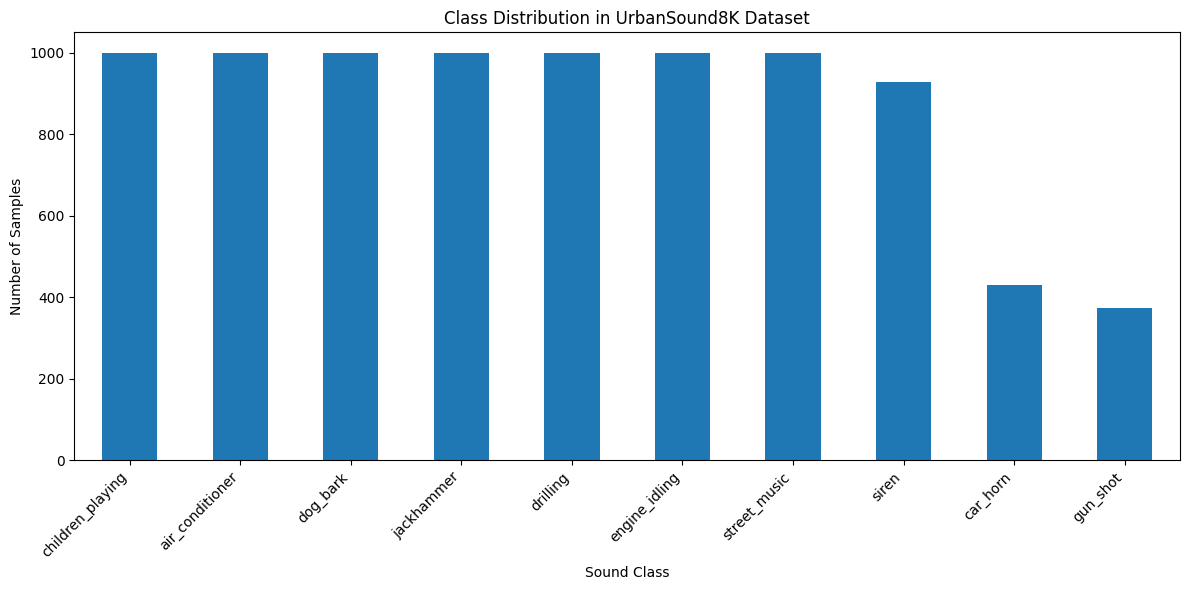

<Figure size 1000x600 with 0 Axes>

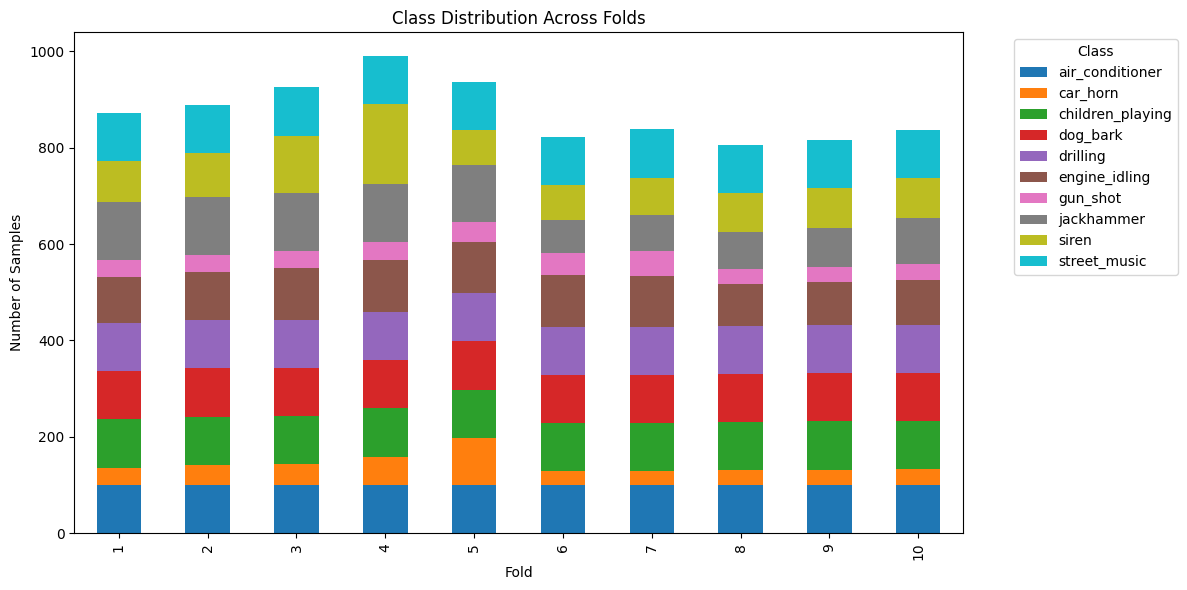

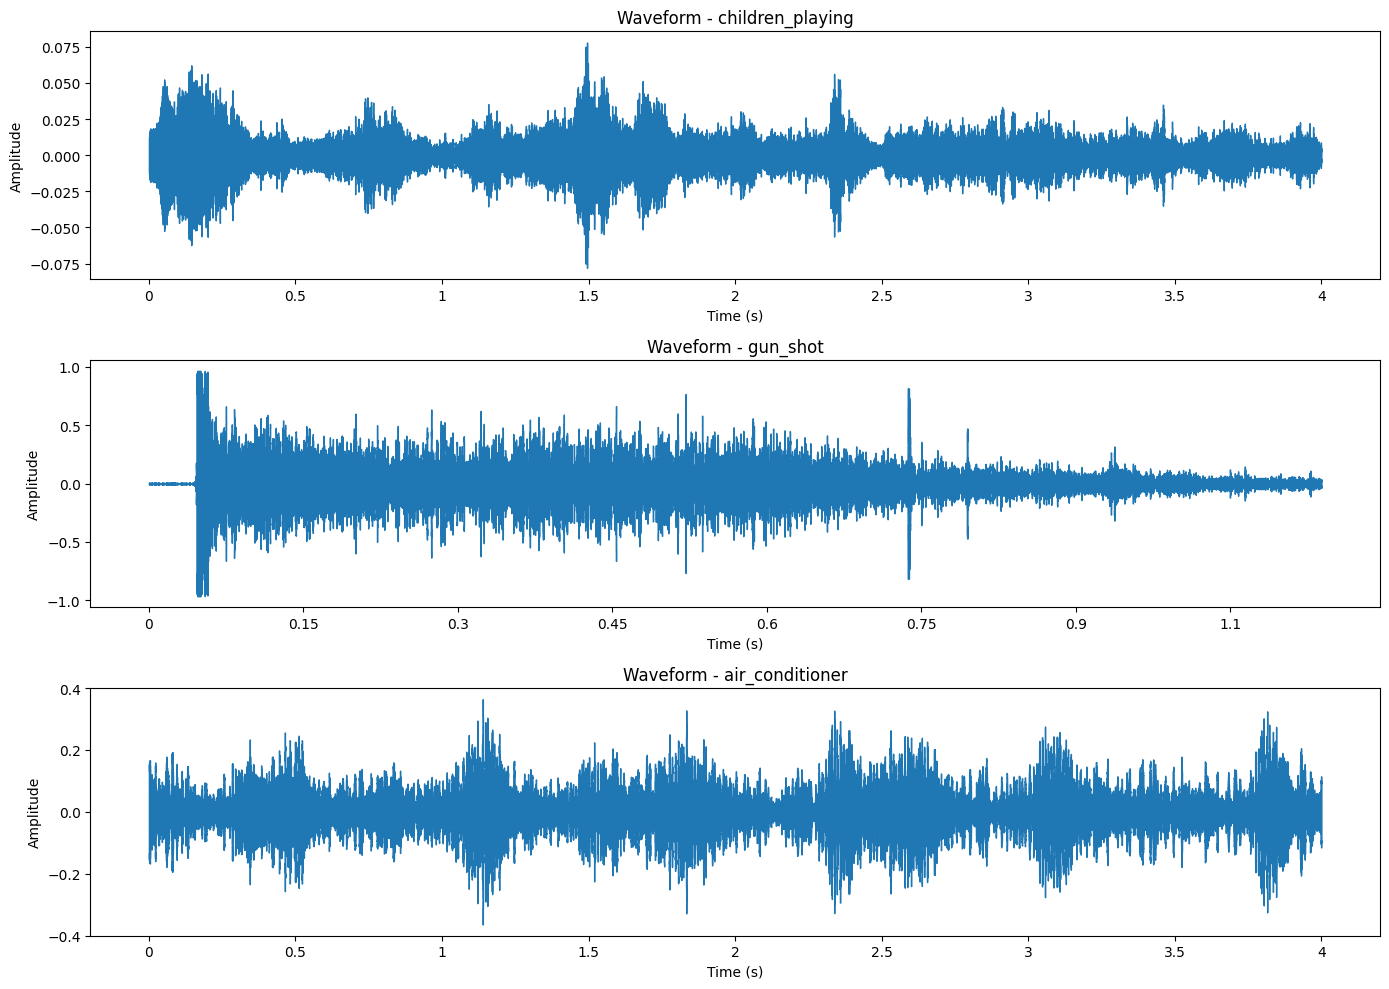

In [8]:
plt.figure(figsize=(12, 6))
metadata['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution in UrbanSound8K Dataset')
plt.xlabel('Sound Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
fold_class_counts = metadata.groupby(['fold', 'class']).size().unstack(fill_value=0)
fold_class_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Class Distribution Across Folds')
plt.xlabel('Fold')
plt.ylabel('Number of Samples')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

sample_classes = metadata['class'].unique()[:3]
fig, axes = plt.subplots(len(sample_classes), 1, figsize=(14, 10))

for idx, class_name in enumerate(sample_classes):
    sample_row = metadata[metadata['class'] == class_name].iloc[0]
    clip = urbansound8k.clip(sample_row['slice_file_name'])
    y, sr = clip.audio

    librosa.display.waveshow(y, sr=sr, ax=axes[idx])
    axes[idx].set_title(f'Waveform - {class_name}')
    axes[idx].set_xlabel('Time (s)')
    axes[idx].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


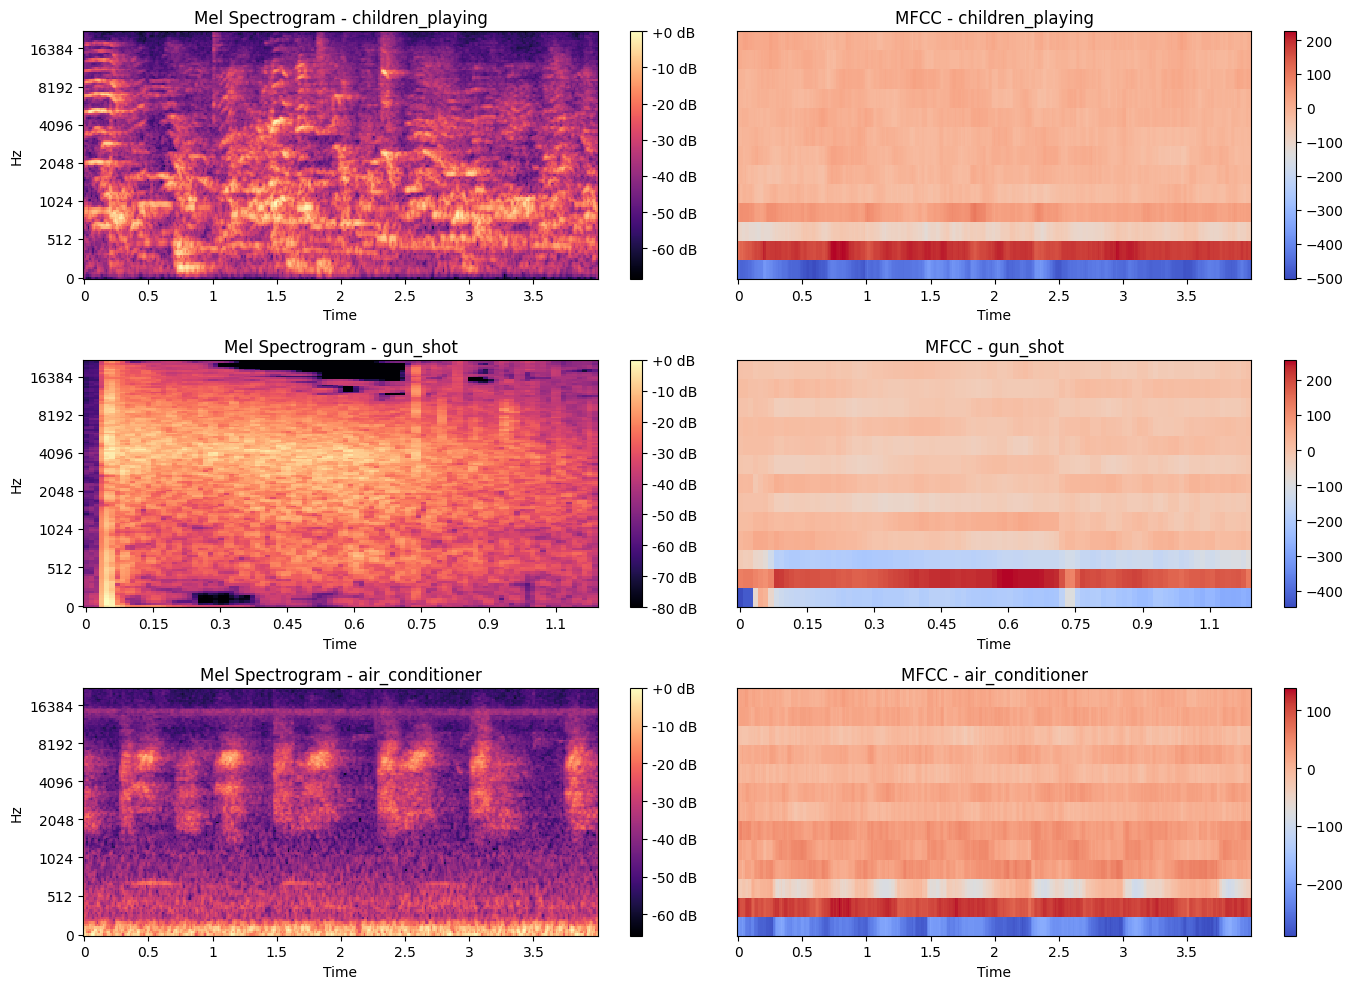

In [9]:
sample_classes = metadata['class'].unique()[:3]
fig, axes = plt.subplots(len(sample_classes), 2, figsize=(14, 10))

for idx, class_name in enumerate(sample_classes):
    sample_row = metadata[metadata['class'] == class_name].iloc[0]
    clip = urbansound8k.clip(sample_row['slice_file_name'])
    y, sr = clip.audio

    # Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Mel Spectrogram - {class_name}')
    fig.colorbar(img, ax=axes[idx, 0], format='%+2.0f dB')

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    img2 = librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=axes[idx, 1])
    axes[idx, 1].set_title(f'MFCC - {class_name}')
    fig.colorbar(img2, ax=axes[idx, 1])

plt.tight_layout()
plt.show()

In [10]:
class UrbanSoundDataset(Dataset):
    def __init__(self, metadata, soundata_loader, transform=None, augment=False):
        self.metadata = metadata.reset_index(drop=True)
        self.soundata_loader = soundata_loader
        self.transform = transform
        self.augment = augment

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.metadata['class'])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        clip = self.soundata_loader.clip(row['slice_file_name'])
        y, sr = clip.audio

        # Apply augmentations
        if self.augment:
            if random.random() > 0.5:
                y = self.pitch_shift(y, sr)
            if random.random() > 0.5:
                y = self.time_stretch(y)
            if random.random() > 0.5:
                y = self.add_noise(y)

        # Pad or truncate to 4 seconds
        target_length = sr * 4
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]

        # Extract mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-6)

        # Convert to tensor
        mel_spec_tensor = torch.FloatTensor(mel_spec_db).unsqueeze(0)

        if self.transform:
            mel_spec_tensor = self.transform(mel_spec_tensor)

        label = self.labels[idx]

        return mel_spec_tensor, label

    def pitch_shift(self, y, sr, n_steps=None):
        if n_steps is None:
            n_steps = random.randint(-3, 3)
        return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

    def time_stretch(self, y, rate=None):
        if rate is None:
            rate = random.uniform(0.8, 1.2)
        return librosa.effects.time_stretch(y, rate=rate)

    def add_noise(self, y, noise_factor=None):
        if noise_factor is None:
            noise_factor = random.uniform(0.001, 0.005)
        noise = np.random.randn(len(y))
        return y + noise_factor * noise

In [11]:
train_metadata = metadata[metadata['fold'] != 10].copy()
test_metadata = metadata[metadata['fold'] == 10].copy()

print(f"Training samples: {len(train_metadata)}")
print(f"Testing samples: {len(test_metadata)}")

# Create datasets
train_dataset = UrbanSoundDataset(train_metadata, urbansound8k, augment=True)
test_dataset = UrbanSoundDataset(test_metadata, urbansound8k, augment=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check sample
sample_mel, sample_label = train_dataset[0]
print(f"Mel spectrogram shape: {sample_mel.shape}")
print(f"Label: {sample_label} (Class: {train_dataset.label_encoder.inverse_transform([sample_label])[0]})")

Training samples: 7895
Testing samples: 837
Mel spectrogram shape: torch.Size([1, 128, 345])
Label: 2 (Class: children_playing)


In [12]:
class SimpleCNN(nn.Module):
    # Basic CNN with 4 convolutional layers
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256 * 8 * 21, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [13]:
class DeepCNN(nn.Module):
    # Deeper CNN with 6 convolutional layers and global pooling
    def __init__(self, num_classes=10):
        super(DeepCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [14]:
class CRNN(nn.Module):
    # Convolutional Recurrent Neural Network with BiLSTM
    def __init__(self, num_classes=10):
        super(CRNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size=256*16, hidden_size=128, num_layers=2,
                           batch_first=True, dropout=0.3, bidirectional=True)

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # CNN layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Reshape for LSTM: (batch, time_steps, features)
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous().view(batch_size, width, channels * height)

        # LSTM layers
        x, _ = self.lstm(x)
        x = x[:, -1, :]

        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [15]:
class ResidualBlock(nn.Module):
    # Residual block for ResNet architecture
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [16]:
class ResNetAudio(nn.Module):
    # ResNet architecture adapted for audio classification
    def __init__(self, num_classes=10):
        super(ResNetAudio, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [17]:
def train_model(model, train_loader, criterion, optimizer, device):
    # Training loop for one epoch
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [18]:
def evaluate_model(model, test_loader, criterion, device):
    # Evaluation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

In [23]:
def train_and_evaluate(model, model_name, train_loader, test_loader, num_epochs=30, lr=0.001):
    # Complete training and evaluation pipeline
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_acc = 0.0

    print(f"\nTraining {model_name}")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate_model(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_best.pth')
            print(f"Model saved with accuracy: {best_acc:.2f}%")

    # Load best model
    model.load_state_dict(torch.load(f'{model_name}_best.pth'))

    return model, train_losses, train_accs, val_losses, val_accs

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
# Train SimpleCNN
simple_cnn = SimpleCNN(num_classes=10)
simple_cnn, simple_train_losses, simple_train_accs, simple_val_losses, simple_val_accs = train_and_evaluate(
    simple_cnn, "SimpleCNN", train_loader, test_loader, num_epochs=30, lr=0.001
)


Training SimpleCNN

Epoch 1/30


Training:  53%|█████▎    | 131/247 [20:34<17:44,  9.18s/it]